# Recommender for MovieLens

### Getting MovieLens data

In [32]:
!unzip /resources/data/ml-100k.zip -d /resources/data

Archive:  /resources/data/ml-100k.zip
replace /resources/data/ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Building the recommender

In [3]:
# import required libraries
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from heapq import nlargest
from sklearn.metrics import mean_squared_error
from math import sqrt
import os.path

In [7]:
# define constant for movie lends 100K directory
MOVIELENS_DIR = "/resources/data/ml-100k/"

## Loading the data

First, we inspect the directory content

In [8]:
!ls $MOVIELENS_DIR

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


We then load the full MovieLens 100K dataset to find the number of users and items

In [9]:
fields = ['userID', 'itemID', 'rating', 'timestamp']
ratingDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.data'), sep='\t', names=fields)

ratingDF.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [10]:
numUsers = len(ratingDF.userID.unique())
numItems = len(ratingDF.itemID.unique())

print("Number of users:", numUsers)
print("Number of items:", numItems)

Number of users: 943
Number of items: 1682


In [11]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Then, we load a train-test split

In [12]:
trainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u1.base'), sep='\t', names=fields)
testDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u1.test'), sep='\t', names=fields)

# test number of records (total should be 100K)
print("# of lines in train:", trainDF.shape[0])
print("# of lines in test:", testDF.shape[0])

# of lines in train: 80000
# of lines in test: 20000


## Building User-to-Item Rating Matrix

In [13]:
def buildUserItemMatrix(dataset, numUsers, numItems):
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((numUsers, numItems), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in dataset.itertuples():
        matrix[userID-1, itemID-1] = rating
    return matrix

In [14]:
trainUserItemMatrix = buildUserItemMatrix(trainDF, numUsers, numItems)
testUserItemMatrix = buildUserItemMatrix(testDF, numUsers, numItems)

In [15]:
# Inspect the train matrix
trainUserItemMatrix

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

## Baseline solution - Average User Rating

In [77]:
def predictByUserAverage(trainSet, numUsers, numItems):
    # Initialize the predicted rating matrix with zeros
    predictionMatrix = np.zeros((numUsers, numItems))
    
    for (user,item), rating in np.ndenumerate(trainSet):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
        if rating == 0:
            # Extract the items the user already rated
            userVector = trainSet[user, :]
            ratedItems = userVector[userVector.nonzero()]
            
            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))
    
    return predictionMatrix

In [78]:
userAvgPrediction = predictByUserAverage(trainUserItemMatrix, numUsers, numItems)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## How well did we do?

In [79]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

## User-User Similarity

In [51]:
userSimilarity = 1 - pairwise_distances(trainUserItemMatrix, metric='cosine')

In [52]:
def predictByUserSimilarity(trainSet, numUsers, numItems, similarity):
    # Initialize the predicted rating matrix with zeros
    predictionMatrix = np.zeros((numUsers, numItems))
    
    for (user,item), rating in np.ndenumerate(trainSet):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
        if rating == 0:
            # Extract the users that provided rating for this item
            itemVector = trainSet[:,item]
            usersRatings = itemVector[itemVector.nonzero()]
            
            # Get the similarity score for each of the users that provided rating for this item
            usersSim = similarity[user,:][itemVector.nonzero()]
            
            # If there no users that ranked this item, use user's average
            if len(usersSim) == 0:
                userVector = trainSet[user, :]
                ratedItems = userVector[userVector.nonzero()]
                
                # If the user didnt rated any item use 0, otherwise use average
                if len(ratedItems) == 0:
                    predictionMatrix[user,item] = 0
                else:
                    predictionMatrix[user,item] = ratedItems.mean()
            else:
                # predict score based on user-user similarity
                predictionMatrix[user,item] = (usersRatings*usersSim).sum() / usersSim.sum()
        
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))
    
    return predictionMatrix

In [53]:
userSimPrediction = predictByUserSimilarity(trainUserItemMatrix, numUsers, numItems, userSimilarity)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [84]:
rmse(userSimPrediction, testUserItemMatrix)

1.026449013124381

## Precision@k and Recall@k

In [85]:
def avgPrecisionAtK(testSet, prediction, k):
    # Initialize sum and count vars for average calculation
    sumPrecisions = 0
    countPrecisions = 0
    
    # Define function for converting 1-5 rating to 0/1 (like / don't like)
    vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
    for userID in range(numUsers):
        # Pick top K based on predicted rating
        userVector = prediction[userID,:]
        topK = nlargest(k, range(len(userVector)), userVector.take)
        
        # Convert test set ratings to like / don't like
        userTestVector = vf(testSet[userID,:]).nonzero()[0]
        
        # Calculate precision
        precision = len([item for item in topK if item in userTestVector])/len(topK)
        
        # Update sum and count
        sumPrecisions += precision
        countPrecisions += 1
        
    # Return average P@k
    return sumPrecisions/countPrecisions

In [86]:
def avgRecallAtK(testSet, prediction, k):
    # Initialize sum and count vars for average calculation
    sumRecalls = 0
    countRecalls = 0
    
    # Define function for converting 1-5 rating to 0/1 (like / don't like)
    vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
    for userID in range(numUsers):
        # Pick top K based on predicted rating
        userVector = prediction[userID,:]
        topK = nlargest(k, range(len(userVector)), userVector.take)
        
        # Convert test set ratings to like / don't like
        userTestVector = vf(testSet[userID,:]).nonzero()[0]
        
        # Ignore user if has no ratings in the test set
        if (len(userTestVector) == 0):
            continue
        
        # Calculate recall
        recall = len([item for item in topK if item in userTestVector])/len(userTestVector)
        
        # Update sum and count
        sumRecalls += recall
        countRecalls += 1
    
    # Return average R@k
    return sumRecalls/countRecalls

In [87]:
print("k\tP@k\tR@k")
for k in [25, 50, 100, 250, 500]:
    print("%d\t%.3lf\t%.3lf" % (k, avgPrecisionAtK(testUserItemMatrix, userSimPrediction, k), avgRecallAtK(testUserItemMatrix, userSimPrediction, k)))

k	P@k	R@k
25	0.020	0.043
50	0.026	0.110
100	0.024	0.202
250	0.021	0.398
500	0.017	0.683


## Popularity Based Recommendations

In [40]:
def predictByPopularity(trainSet, numUsers, numItems):
    # Initialize the predicted rating matrix with zeros
    predictionMatrix = np.zeros((numUsers, numItems))
    
    # Define function for converting 1-5 rating to 0/1 (like / don't like)
    vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
    # For every item calculate the number of people liked (4-5) divided by the number of people that rated
    itemPopularity = np.zeros((numItems))
    for item in range(numItems):
        numOfUsersRated = len(trainSet[:, item].nonzero()[0])
        numOfUsersLiked = len(vf(trainSet[:, item]).nonzero()[0])
        if numOfUsersRated == 0:
            itemPopularity[item] = 0
        else:
            itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    
    for (user,item), rating in np.ndenumerate(trainSet):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
        if rating == 0:
            predictionMatrix[user, item] = itemPopularity[item]
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))
    
    return predictionMatrix

In [41]:
popPrediction = predictByPopularity(trainUserItemMatrix, numUsers, numItems)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [90]:
print("k\tP@k\tR@k")
for k in [25, 50, 100, 250, 500]:
    print("%d\t%.3lf\t%.3lf" % (k, avgPrecisionAtK(testUserItemMatrix, popPrediction, k), avgRecallAtK(testUserItemMatrix, popPrediction, k)))

k	P@k	R@k
25	0.000	0.000
50	0.004	0.015
100	0.019	0.155
250	0.021	0.400
500	0.017	0.688


In [91]:
PopularityRMSE = rmse(popPrediction, testUserItemMatrix)
PopularityRMSE

3.177941281084362

## Making Recommendations for a User

In [75]:
def userTopK(prediction, moviesDataset, userID, k):
    # Pick top K based on predicted rating
    userVector = prediction[userID+1,:]
    topK = nlargest(k, range(len(userVector)), userVector.take)
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topK))
    return namesTopK

In [76]:
# recommend for userID 350 according to popularity recommender
userTopK(popPrediction, moviesDF, 350, 10)

['Loch Ness (1995)',
 'Perfect Candidate, A (1996)',
 'Love and Death on Long Island (1997)',
 'Crossfire (1947)',
 'Celestial Clockwork (1994)',
 'They Made Me a Criminal (1939)',
 'Last Time I Saw Paris, The (1954)',
 'Innocents, The (1961)',
 "Jupiter's Wife (1994)",
 'Prefontaine (1997)']

In [94]:
# recommend for userID 350 according to average rating recommender
userTopK(userAvgPrediction, moviesDF, 350, 10)

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Twelve Monkeys (1995)',
 'Babe (1995)',
 'Dead Man Walking (1995)',
 'Richard III (1995)']

In [95]:
# recommend for userID 350 according to user similarity recommender
userTopK(userSimPrediction, moviesDF, 350, 10)

['Saint of Fort Washington, The (1993)',
 'They Made Me a Criminal (1939)',
 'Prefontaine (1997)',
 'Marlene Dietrich: Shadow and Light (1996) ',
 'Star Kid (1997)',
 'Santa with Muscles (1996)',
 "Someone Else's America (1995)",
 'Entertaining Angels: The Dorothy Day Story (1996)',
 'Faust (1994)',
 'Pather Panchali (1955)']

## Evaluating the other datasets

In [96]:
datasetsFileNames = [('u1.base', 'u1.test'),
                     ('u2.base', 'u2.test'),
                     ('u3.base', 'u3.test'),
                     ('u4.base', 'u4.test'),
                     ('u5.base', 'u5.test')]

In [ ]:
rmseList = []
for trainFileName, testFileName in datasetsFileNames:
    curTrainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, trainFileName), sep='\t', names=fields)
    curTestDF = pd.read_csv(os.path.join(MOVIELENS_DIR, testFileName), sep='\t', names=fields)
    curTrainUserItemMatrix = buildUserItemMatrix(curTrainDF, numUsers, numItems)
    curTestUserItemMatrix = buildUserItemMatrix(curTestDF, numUsers, numItems)
    
    curUserAvgPrediction = predictByUserAverage(curTrainUserItemMatrix, numUsers, numItems)
    avgRMSE = rmse(curUserAvgPrediction, curTestUserItemMatrix)
    
    curUserSimilarity = 1 - pairwise_distances(curTrainUserItemMatrix, metric='cosine')
    curUserSimPrediction = predictByUserSimilarity(curTrainUserItemMatrix, numUsers, numItems, curUserSimilarity)
    simRMSE = rmse(curUserSimPrediction, curTestUserItemMatrix)
    
    rmseList.append((avgRMSE, simRMSE))

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users


KeyboardInterrupt: 

In [ ]:
print("Avg\tSim")
for avgScore, simScore in rmseList:
    print("%.3lf\t%.3lf" % (avgScore, simScore))

In [ ]:
datasetsFileNames = [('u1.base', 'u1.test'),
                     ('u2.base', 'u2.test'),
                     ('u3.base', 'u3.test'),
                     ('u4.base', 'u4.test'),
                     ('u5.base', 'u5.test')]

In [ ]:
# Cosine distance for all datasets

In [70]:
rmseList = []
for trainFileName, testFileName in datasetsFileNames:
    curTrainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, trainFileName), sep='\t', names=fields)
    curTestDF = pd.read_csv(os.path.join(MOVIELENS_DIR, testFileName), sep='\t', names=fields)
    curTrainUserItemMatrix = buildUserItemMatrix(curTrainDF, numUsers, numItems)
    curTestUserItemMatrix = buildUserItemMatrix(curTestDF, numUsers, numItems)
    
    
    curUserSimilarity = 1 - pairwise_distances(curTrainUserItemMatrix, metric='cosine')
    curUserSimPrediction = predictByUserSimilarity(curTrainUserItemMatrix, numUsers, numItems, curUserSimilarity)
    simRMSE = rmse(curUserSimPrediction, curTestUserItemMatrix)
    
    rmseList.append((simRMSE))

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
ca

In [71]:
print("Sim")
for simScore in rmseList:
    print("%.3lf" % (simScore))

Sim
1.026
1.021
1.013
1.009
1.016


# Euclidean and Cosine Comparison

In [75]:
rmseList = []
for trainFileName, testFileName in datasetsFileNames:
    curTrainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, trainFileName), sep='\t', names=fields)
    curTestDF = pd.read_csv(os.path.join(MOVIELENS_DIR, testFileName), sep='\t', names=fields)
    curTrainUserItemMatrix = buildUserItemMatrix(curTrainDF, numUsers, numItems)
    curTestUserItemMatrix = buildUserItemMatrix(curTestDF, numUsers, numItems)
    
    curUserSimilarity = 1 - pairwise_distances(curTrainUserItemMatrix, metric='cosine')
    curUserSimPrediction = predictByUserSimilarity(curTrainUserItemMatrix, numUsers, numItems, curUserSimilarity)
    simRMSE = rmse(curUserSimPrediction, curTestUserItemMatrix)
    
    curUserSimilarityEuc = 1 / pairwise_distances(curTrainUserItemMatrix)
    curUserSimPredictionEuc = predictByUserSimilarity(curTrainUserItemMatrix, numUsers, numItems, curUserSimilarityEuc)
    simRMSEEuc = rmse(curUserSimPredictionEuc, curTestUserItemMatrix)
    
    rmseList.append((simRMSE, simRMSEEuc))

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
ca

In [80]:
print("SimCos\tSimEuc")
for simScoreCos, simScoreEuc in rmseList:
    print("%.3lf\t%.3lf" % (simScoreCos, simScoreEuc))
 

SimCos	SimEuc
1.026	1.032
1.021	1.027
1.013	1.018
1.009	1.015
1.016	1.021


In [1]:
from scipy import stats
mean = np.mean(rmseList, axis=0)
sigma = np.std(rmseList, axis=0)
print("Cosine 5-fold cross validation average:", mean[0])
print("Cosine 95% confidence interval:", stats.norm.interval(0.95, loc=mean[0], scale=sigma[0]))
print("Eucledian 5-fold cross validation average:", mean[1])
print("Eucledian 95% confidence interval:", stats.norm.interval(0.95, loc=mean[1], scale=sigma[1]))



NameError: name 'np' is not defined

### Cityblock metric

In [118]:
rmseListCB = []
for trainFileName, testFileName in datasetsFileNames:
    curTrainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, trainFileName), sep='\t', names=fields)
    curTestDF = pd.read_csv(os.path.join(MOVIELENS_DIR, testFileName), sep='\t', names=fields)
    curTrainUserItemMatrix = buildUserItemMatrix(curTrainDF, numUsers, numItems)
    curTestUserItemMatrix = buildUserItemMatrix(curTestDF, numUsers, numItems)
    
    
    curUserSimilarityCB = 1 / pairwise_distances(curTrainUserItemMatrix, metric='cityblock')
    curUserSimPredictionCB = predictByUserSimilarity(curTrainUserItemMatrix, numUsers, numItems, curUserSimilarityCB)
    simRMSECB = rmse(curUserSimPredictionCB, curTestUserItemMatrix)
    
    rmseListCB.append((simRMSECB))

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
ca

In [119]:
print("Sim")
for simScoreCB in rmseListCB:
    print("%.3lf" % (simScoreCB))
mean = np.mean(rmseListCB)
sigma = np.std(rmseListCB)
print("Cityblock 5-fold cross validation average:", mean)
print("Cityblock 95% confidence interval:", stats.norm.interval(0.95, loc=mean, scale=sigma))
  

Sim
1.032
1.027
1.017
1.015
1.021
Cityblock 5-fold cross validation average: 1.02239932304
Cityblock 95% confidence interval: (1.0098786564546642, 1.0349199896201695)


In [157]:
trainItemUserMatrix = trainUserItemMatrix.T
trainItemUserMatrix

array([[5, 4, 0, ..., 5, 0, 0],
       [3, 0, 0, ..., 0, 0, 5],
       [4, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [159]:
itemSimilarity = 1 - pairwise_distances(trainItemUserMatrix, metric='cosine')

def predictByItemSimilarity(trainSet, numItems, numUsers, similarity):
    # Initialize the predicted rating matrix with zeros
    predictionMatrixT = np.zeros((numItems, numUsers))
    
    for (item, user), rating in np.ndenumerate(trainSet):
        if rating == 0:
            
            userVector = trainSet[:,user]
            itemsRatings = userVector[userVector.nonzero()]
            
            itemsSim = similarity[item,:][userVector.nonzero()]
            
            if len(itemsSim) or itemsSim.sum == 0 :
                itemVector = trainSet[item, :]
                ratedUsers = itemVector[itemVector.nonzero()]
                
                if len(ratedUsers) == 0:
                    predictionMatrixT[item, user] = 0
                else:
                    predictionMatrixT[item, user] = ratedUsers.mean()
                    
            
            else:
                # predict score based on item-item similarity
                predictionMatrixT[item, user] = (itemsRatings*itemsSim).sum() / itemsSim.sum()
        
        # report progress every 100 items
        if (item % 100 == 0 and user == 1):
            print ("calculated %d items" % (item,))
    
    return predictionMatrixT

In [160]:
itemSimPrediction = predictByItemSimilarity(trainUserItemMatrixTranspose, numItems, numUsers, itemSimilarity)

calculated 0 items
calculated 100 items
calculated 200 items
calculated 300 items
calculated 400 items
calculated 500 items
calculated 600 items
calculated 700 items
calculated 800 items
calculated 900 items
calculated 1000 items
calculated 1100 items
calculated 1200 items
calculated 1300 items
calculated 1400 items
calculated 1500 items
calculated 1600 items


In [20]:
testUserItemMatrixTranspose = testUserItemMatrix.T

rmse(itemSimPrediction, testUserItemMatrixTranspose)

NameError: name 'rmse' is not defined

In [140]:
rmseList = []
for trainFileName, testFileName in datasetsFileNames:
    curTrainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, trainFileName), sep='\t', names=fields)
    curTestDF = pd.read_csv(os.path.join(MOVIELENS_DIR, testFileName), sep='\t', names=fields)
    curTrainUserItemMatrix = buildUserItemMatrix(curTrainDF, numUsers, numItems)
    curTestUserItemMatrix = buildUserItemMatrix(curTestDF, numUsers, numItems)
    curTrainItemUserMatrix = curTrainUserItemMatrix.T
    curTestItemUserMatrix = curTestUserItemMatrix.T
    
    curUserSimilarity = 1 - pairwise_distances(curTrainUserItemMatrix, metric='cosine')
    curUserSimPrediction = predictByUserSimilarity(curTrainUserItemMatrix, numUsers, numItems, curUserSimilarity)
    simUserRMSE = rmse(curUserSimPrediction, curTestUserItemMatrix)
    
    curItemSimilarity = 1 - pairwise_distances(curTrainItemUserMatrix, metric='cosine')
    curItemSimPrediction = predictByItemSimilarity(curTrainItemUserMatrix, numItems, numUsers, curItemSimilarity)
    simItemRMSE = rmse(curItemSimPrediction, curTestItemUserMatrix)
    
    rmseList.append((simUserRMSE, simItemRMSE))

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 items
calculated 100 items
calculated 200 items
calculated 300 items
calculated 400 items
calculated 500 items
calculated 600 items
calculated 700 items
calculated 800 items
calculated 900 items
calculated 1000 items
calculated 1100 items
calculated 1200 items
calculated 1300 items
calculated 1400 items
calculated 1500 items
calculated 1600 items
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users
calculated 0 items
calculated 100 items
calculated 200 items
calculated 300 items
calculated 400 items
calculated 500 items
calculated 600 items
calculated 700 items
calculated 800 items
calculated 900 items
calculated 100

In [141]:
print("User RMSE\tItem RMSE")
for UserRMSE, ItemRMSE in rmseList:
    print("%.3lf\t%.3lf" % (UserRMSE, ItemRMSE))

User RMSE	Item RMSE
1.026	1.036
1.021	1.031
1.013	1.024
1.009	1.019
1.016	1.028


In [142]:
mean = np.mean(rmseList, axis=0)
sigma = np.std(rmseList, axis=0)
print("User Similarity 5-fold cross validation average:", mean[0])
print("User Similarity 95% confidence interval:", stats.norm.interval(0.95, loc=mean[0], scale=sigma[0]))
print("Item Similarity 5-fold cross validation average:", mean[1])
print("Item Similarity 95% confidence interval:", stats.norm.interval(0.95, loc=mean[1], scale=sigma[1]))



User Similarity 5-fold cross validation average: 1.01735412166
User Similarity 95% confidence interval: (1.0055778104528141, 1.0291304328683475)
Item Similarity 5-fold cross validation average: 1.02783566413
Item Similarity 95% confidence interval: (1.0165619126170875, 1.0391094156430194)


In [69]:
rmseList = []
i=0
userAvgMetrics = []
userSimMetrics = []
itemSimMetrics = []
popularityMetrics = []

for trainFileName, testFileName in datasetsFileNames:
    i=i+1
    curTrainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, trainFileName), sep='\t', names=fields)
    curTestDF = pd.read_csv(os.path.join(MOVIELENS_DIR, testFileName), sep='\t', names=fields)
    curTrainUserItemMatrix = buildUserItemMatrix(curTrainDF, numUsers, numItems)
    curTestUserItemMatrix = buildUserItemMatrix(curTestDF, numUsers, numItems)
    curTrainItemUserMatrix = curTrainUserItemMatrix.T
    curTestItemUserMatrix = curTestUserItemMatrix.T
    
    curUserAvgPrediction = predictByUserAverage(curTrainUserItemMatrix, numUsers, numItems)
    avgRMSE = rmse(curUserAvgPrediction, curTestUserItemMatrix)
    
    curUserSimilarity = 1 - pairwise_distances(curTrainUserItemMatrix, metric='cosine')
    curUserSimPrediction = predictByUserSimilarity(curTrainUserItemMatrix, numUsers, numItems, curUserSimilarity)
    simUserRMSE = rmse(curUserSimPrediction, curTestUserItemMatrix)
    
    curItemSimilarity = 1 - pairwise_distances(curTrainItemUserMatrix, metric='cosine')
    curItemSimPrediction = predictByItemSimilarity(curTrainItemUserMatrix, numItems, numUsers, curItemSimilarity)
    simItemRMSE = rmse(curItemSimPrediction, curTestItemUserMatrix)
    
    curPopPrediction = predictByPopularity(curTrainUserItemMatrix, numUsers, numItems)
    PopRMSE = rmse(curPopPrediction, curTestUserItemMatrix)

    print("For trial number", i)
    print("k\tP@k\tR@k")
    for k in [25, 50, 100, 250, 500]:
        userAvgMetrics.append((k, avgPrecisionAtK(curTestUserItemMatrix, curUserAvgPrediction, k), avgRecallAtK(curTestUserItemMatrix, curUserAvgPrediction, k)))
        userSimMetrics.append((k, avgPrecisionAtK(curTestUserItemMatrix, curUserSimPrediction, k), avgRecallAtK(curTestUserItemMatrix, curUserSimPrediction, k)))
        itemSimMetrics.append((k, avgPrecisionAtK(curTestItemUserMatrix, curItemSimPrediction, k), avgRecallAtK(curTestItemUserMatrix, curItemSimPrediction, k)))
        popularityMetrics.append((k, avgPrecisionAtK(curTestUserItemMatrix, curPopPrediction, k), avgRecallAtK(curTestUserItemMatrix, curPopPrediction, k)))
        
        print("User Avg:", "%d\t%.3lf\t%.3lf" % (k, avgPrecisionAtK(curTestUserItemMatrix, curUserAvgPrediction, k), avgRecallAtK(curTestUserItemMatrix, curUserAvgPrediction, k)))
        print("User Sim:", "%d\t%.3lf\t%.3lf" % (k, avgPrecisionAtK(curTestUserItemMatrix, curUserSimPrediction, k), avgRecallAtK(curTestUserItemMatrix, curUserSimPrediction, k)))
        print("Item Sim:", "%d\t%.3lf\t%.3lf" % (k, avgPrecisionAtK(curTestItemUserMatrix, curItemSimPrediction, k), avgRecallAtK(curTestItemUserMatrix, curItemSimPrediction, k)))
        print("Popularity:", "%d\t%.3lf\t%.3lf" % (k, avgPrecisionAtK(curTestUserItemMatrix, curPopPrediction, k), avgRecallAtK(curTestUserItemMatrix, curPopPrediction, k)))
    
    rmseList.append((avgRMSE, simUserRMSE, simItemRMSE, PopRMSE))

NameError: name 'datasetsFileNames' is not defined

In [171]:
# RMSE Comparison:

print("avgRMSE\tsimUserRMSE\tsimItemRMSE\tPopRMSE")
for avgRMSE, simUserRMSE, simItemRMSE, PopRMSE in rmseList:
    print("%.3lf\t%.3lf\t%.3lf\t%.3lf" % (avgRMSE, simUserRMSE, simItemRMSE, PopRMSE))
 

avgRMSE	simUserRMSE	simItemRMSE	PopRMSE
1.063	1.026	1.036	3.178
1.047	1.021	1.031	3.175
1.033	1.013	1.024	3.147
1.037	1.009	1.019	3.146
1.039	1.016	1.028	3.149


In [173]:
userAvgMetrics

[(25, 0.02812301166489914, 0.05627338468747922),
 (50, 0.02373276776246013, 0.09070897844058053),
 (100, 0.023743372216330876, 0.17442450189075948),
 (250, 0.023978791092258735, 0.435685310801242),
 (500, 0.018791092258748632, 0.781990949229217),
 (25, 0.02867444326617163, 0.0598575804508166),
 (50, 0.02487804878048768, 0.09458105043959829),
 (100, 0.023849416755037132, 0.1680506311413588),
 (250, 0.023753976670201394, 0.4428752121741389),
 (500, 0.018956521739130403, 0.8025718175445753),
 (25, 0.028971367974549148, 0.06162241054639059),
 (50, 0.02500530222693517, 0.09849524001430465),
 (100, 0.024029692470837746, 0.17783871639317977),
 (250, 0.023711558854718907, 0.4498395233794572),
 (500, 0.018653234358430436, 0.8007223172157748),
 (25, 0.027613997879109065, 0.0585239934041796),
 (50, 0.02386002120890761, 0.09285296548264899),
 (100, 0.023722163308589544, 0.17497145017860072),
 (250, 0.02389395546129362, 0.45890453292402306),
 (500, 0.018638388123011586, 0.8019592557644111),
 (25, 0

In [188]:
# Metrics Comparison:
j=0
print("k\tP@k\tR@k")
print("User Avg:")
for i in userAvgMetrics:
    if j ==0:
        print("For trial number 1")
    elif j%5==0:
        print("For trial number", j/5 + 1)
    print(i)
    j=j+1
print(" ")

j=0
print("User Similarity:")
for i in userSimMetrics:
    if j ==0:
        print("For trial number 1")
    elif j%5==0:
        print("For trial number", j/5 + 1)
    print(i)
    j=j+1
print(" ")

j=0
print("Item Similarity:")
for i in itemSimMetrics:
    if j ==0:
        print("For trial number 1")
    elif j%5==0:
        print("For trial number", j/5 + 1)
    print(i)
    j=j+1
print(" ")

j=0
print("Popularity:")
for i in popularityMetrics:
    if j ==0:
        print("For trial number 1")
    elif j%5==0:
        print("For trial number", j/5 + 1)
    print(i)
    j=j+1
    

k	P@k	R@k
User Avg:
For trial number 1
(25, 0.02812301166489914, 0.05627338468747922)
(50, 0.02373276776246013, 0.09070897844058053)
(100, 0.023743372216330876, 0.17442450189075948)
(250, 0.023978791092258735, 0.435685310801242)
(500, 0.018791092258748632, 0.781990949229217)
For trial number 2.0
(25, 0.02867444326617163, 0.0598575804508166)
(50, 0.02487804878048768, 0.09458105043959829)
(100, 0.023849416755037132, 0.1680506311413588)
(250, 0.023753976670201394, 0.4428752121741389)
(500, 0.018956521739130403, 0.8025718175445753)
For trial number 3.0
(25, 0.028971367974549148, 0.06162241054639059)
(50, 0.02500530222693517, 0.09849524001430465)
(100, 0.024029692470837746, 0.17783871639317977)
(250, 0.023711558854718907, 0.4498395233794572)
(500, 0.018653234358430436, 0.8007223172157748)
For trial number 4.0
(25, 0.027613997879109065, 0.0585239934041796)
(50, 0.02386002120890761, 0.09285296548264899)
(100, 0.023722163308589544, 0.17497145017860072)
(250, 0.02389395546129362, 0.458904532924

In [67]:
# Chosen movies:

# 1) 419|Mary Poppins (1964)
# 2) 420|Alice in Wonderland
# 3) 1135|Doors, The

In [89]:
def simItems(moviesDataset, movieID, k):
    # Pick top K based on predicted rating
    itemVector = itemSimPrediction[:,movieID+1]
    topK = nlargest(k, range(len(itemVector)), itemVector.take)
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topK))
    return namesTopK

array([ 3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  0.  ,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        0.  ,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  0.  ,  3.18,  0.  ,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,  3.18,
        3.18,  3.18,

In [101]:
simItems(moviesDF, 67, 5)

['They Made Me a Criminal (1939)',
 'Prefontaine (1997)',
 'Marlene Dietrich: Shadow and Light (1996) ',
 'Star Kid (1997)',
 'Saint of Fort Washington, The (1993)']

NameError: name 'curItemSimPrediction' is not defined

In [143]:
import matplotlib.pyplot as plt
%matplotib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


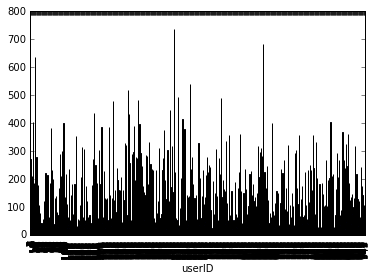

In [144]:
ratingDF.groupby('userID').size().plot(kind='bar')
plt.show()

In [145]:
# Chosen τ = 100